## Paqueterías

In [58]:
import pandas as pd
import numpy as np
from datetime import datetime
from semopy import Model, Optimizer, semplot
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

---

# Proyecto Final
**Laboratorio de Análisis Financiero y de Diseño de Indicadores**

**Integrantes del equipo:**
- Luis Eduardo Jiménez del Muro
- Lenin Adair Quezada Gómez
- José Armando Melchor Soto
- Edgar Alfonso Ramos Gómez

**Fecha: 26/11/2024**

## Funciones del Programa 

## Carga de Datos 

In [2]:
reparaciones = pd.read_csv('reparaciones.csv')
reparaciones = reparaciones[['CLIENTE', 'COHORT', 'DESCRIPCION FALLA', 'INGRESO', 'FECHA REPARACION', 'CLUSTER', 'SIMILITUD COSENO']]

clientes = pd.read_csv('data/CLIENTES.csv', encoding='latin1')
clientes = clientes[['CLIENTE', 'NOMBRES']]

reparaciones

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER,SIMILITUD COSENO
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser,0.298307
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta,0.391361
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser,0.508475
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser,0.493519
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser,0.448675
...,...,...,...,...,...,...,...
9295,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas,0.325016
9296,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas,0.275756
9297,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser,0.458887
9298,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros,0.408079


## Limpieza de los datos

En esta sección principalmente se observará la distribución de las similitudes coseno y establecer un threshold para eliminar la clasificación imprecisa que pudo tener el modelo de embedding vectors.

### Número de fallas por cluster antes de limpieza

Text(0, 0.5, 'CANTIDAD')

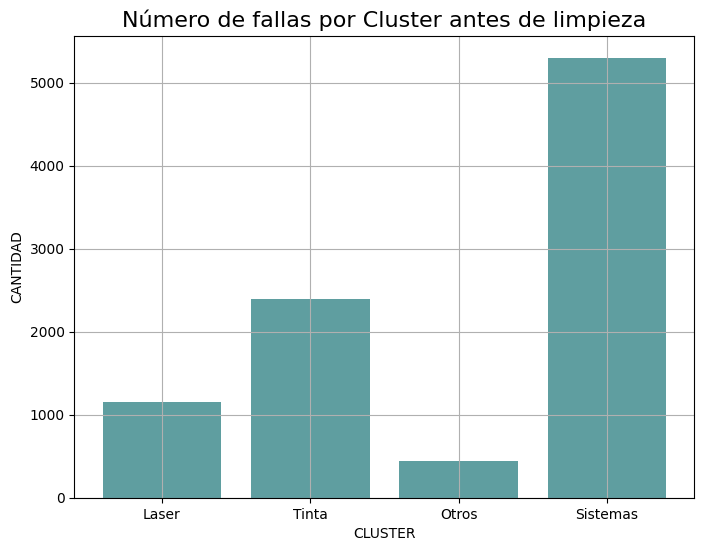

In [3]:
plt.figure(figsize=(8,6))
plt.grid()
plt.bar(['Laser', 'Tinta', 'Otros', 'Sistemas'], reparaciones.groupby('CLUSTER')['CLUSTER'].count(), color='cadetblue')
plt.title('Número de fallas por Cluster antes de limpieza', fontsize=16)
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')

### Distribución de las similitudes coseno

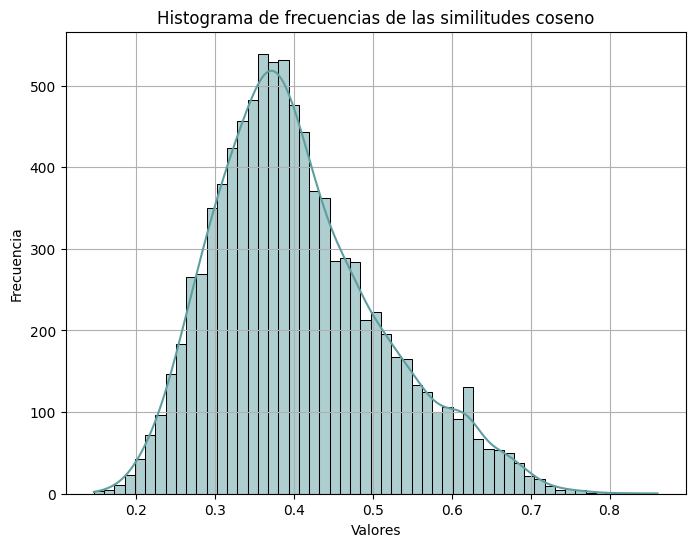

In [4]:
plt.figure(figsize=(8,6))
sns.histplot(reparaciones['SIMILITUD COSENO'], kde=True, color='cadetblue')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de frecuencias de las similitudes coseno')
plt.grid()

### Establecimiento del threshold

Decidimos limpar a partir del percentil ###, lo que significa que no nos interesan los registros que sean menores al percentil ###. Los que estén por encima del percentil ### no tenemos que eliminarlos porque esos representan a los que el modelo relacionó mejor.

In [5]:
threshold = reparaciones['SIMILITUD COSENO'].quantile(0.05)
threshold

0.25578981100000003

### Número de fallas fuera del threshold

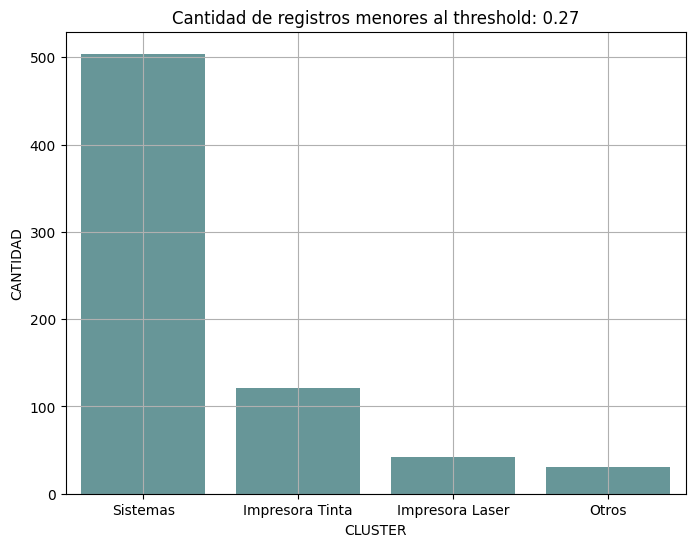

In [6]:
df_filtrado = reparaciones[reparaciones['SIMILITUD COSENO'] < 0.27]

conteo_clusters = df_filtrado['CLUSTER'].value_counts().reset_index()
conteo_clusters.columns = ['CLUSTER', 'cantidad']

plt.figure(figsize=(8,6))
sns.barplot(data=conteo_clusters, x='CLUSTER', y='cantidad', color = 'cadetblue')
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')
plt.title('Cantidad de registros menores al threshold: 0.27')
plt.grid()

In [7]:
reparaciones_thresholded = reparaciones[reparaciones['SIMILITUD COSENO'] >= 0.27].reset_index()
reparaciones_thresholded = reparaciones_thresholded.drop(columns='index')
reparaciones_thresholded

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER,SIMILITUD COSENO
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser,0.298307
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta,0.391361
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser,0.508475
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser,0.493519
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser,0.448675
...,...,...,...,...,...,...,...
8597,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas,0.325016
8598,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas,0.275756
8599,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser,0.458887
8600,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros,0.408079


Text(0, 0.5, 'CANTIDAD')

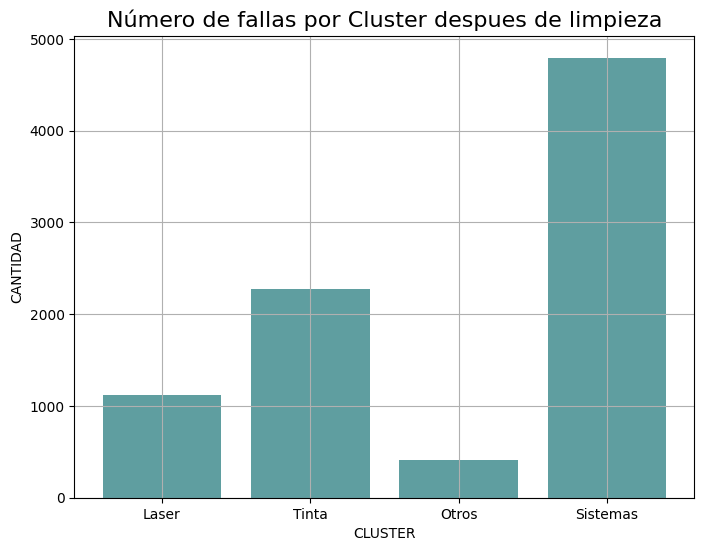

In [8]:
plt.figure(figsize=(8,6))
plt.grid()
plt.bar(['Laser', 'Tinta', 'Otros', 'Sistemas'], reparaciones_thresholded.groupby('CLUSTER')['CLUSTER'].count(), color='cadetblue')
plt.title('Número de fallas por Cluster despues de limpieza', fontsize=16)
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')

In [9]:
reparaciones = reparaciones_thresholded[['CLIENTE', 'COHORT', 'DESCRIPCION FALLA', 'INGRESO', 'FECHA REPARACION', 'CLUSTER']]

## Exploración de Datos 

In [10]:
reparaciones

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser
...,...,...,...,...,...,...
8597,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas
8598,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas
8599,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser
8600,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros


In [11]:
reparaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8602 entries, 0 to 8601
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CLIENTE            8602 non-null   int64  
 1   COHORT             8602 non-null   object 
 2   DESCRIPCION FALLA  8602 non-null   object 
 3   INGRESO            8602 non-null   float64
 4   FECHA REPARACION   8602 non-null   object 
 5   CLUSTER            8602 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 403.3+ KB


In [12]:
reparaciones['FECHA REPARACION'] = reparaciones['FECHA REPARACION'].str.replace('-', '/')
reparaciones['COHORT'] = reparaciones['COHORT'].str.replace('-', '/')

reparaciones['FECHA REPARACION'] = pd.to_datetime(reparaciones['FECHA REPARACION'], dayfirst=True, errors='coerce')
reparaciones['COHORT'] = pd.to_datetime(reparaciones['COHORT'], dayfirst=True, errors='coerce')

current_date = datetime.now()
reparaciones.loc[reparaciones['FECHA REPARACION'] > current_date, 'FECHA REPARACION'] = pd.NaT
reparaciones.loc[reparaciones['COHORT'] > current_date, 'COHORT'] = pd.NaT

reparaciones = reparaciones.dropna(subset='FECHA REPARACION')
reparaciones = reparaciones.dropna(subset='COHORT')

reparaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8593 entries, 0 to 8601
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CLIENTE            8593 non-null   int64         
 1   COHORT             8593 non-null   datetime64[ns]
 2   DESCRIPCION FALLA  8593 non-null   object        
 3   INGRESO            8593 non-null   float64       
 4   FECHA REPARACION   8593 non-null   datetime64[ns]
 5   CLUSTER            8593 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 469.9+ KB


### Identificar primer ticket por cliente. 

In [53]:
reparaciones_sorted = reparaciones.sort_values(by=['CLIENTE', 'FECHA REPARACION'])
first_ticket_df = reparaciones_sorted.groupby('CLIENTE').first().reset_index()
first_ticket_df = first_ticket_df[['CLIENTE', 'CLUSTER', 'INGRESO']]
first_ticket_df.head()

,CLIENTE,CLUSTER,INGRESO
0,2,Impresora Laser,1820.0
1,3,Sistemas,360.0
2,4,Sistemas,300.0
3,5,Sistemas,480.0
4,6,Sistemas,500.0


## Análisis y cálculo de los KPIs

### Customer Lifetime Value (24 Meses)

In [13]:
snapshot_date = reparaciones['FECHA REPARACION'].max()
snapshot_date

Timestamp('2024-10-18 00:00:00')

In [14]:
reparaciones['FECHA REPARACION'].min()

Timestamp('2017-12-04 00:00:00')

In [15]:
reparaciones['CUSTOMER_TENURE'] = (snapshot_date.year - reparaciones['FECHA REPARACION'].dt.year)*12 + (
    snapshot_date.month - reparaciones['FECHA REPARACION'].dt.month)

reparaciones['CUSTOMER_TENURE_ON_TRANSACTION'] = (
    reparaciones['FECHA REPARACION'].dt.year - reparaciones['COHORT'].dt.year)*12 + (
    reparaciones['FECHA REPARACION'].dt.month - reparaciones['COHORT'].dt.month
)

cltv_24_months = reparaciones[
    (reparaciones['CUSTOMER_TENURE'] > 24) &
    (reparaciones['CUSTOMER_TENURE_ON_TRANSACTION'] <= 24)
].groupby('CLIENTE')['INGRESO'].sum().reset_index()
cltv_24_months = cltv_24_months.rename(columns={'INGRESO':'LTV_24_MESES'})

cltv_nombres = cltv_24_months.merge(clientes, on='CLIENTE', how='inner') # Para poder observar los nombres de los clientes

cltv_24_months.head()

,CLIENTE,LTV_24_MESES
0,2,10200.0
1,3,31575.0
2,4,142495.8
3,5,32372.0
4,6,13021.0


## Visualización de las variables relacionadas. 

### LTV por cohort

<Axes: xlabel='COHORT'>

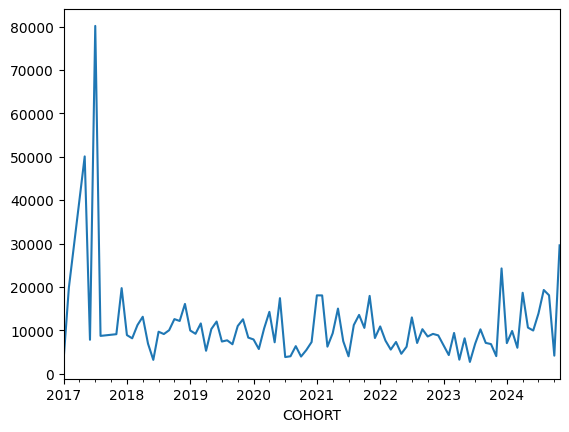

In [63]:
reparaciones_ltv = reparaciones.merge(cltv_24_months, on='CLIENTE', how='inner')
reparaciones_cohort_m = reparaciones_ltv[['CLIENTE', 'COHORT', 'LTV_24_MESES']]
reparaciones_cohort_m['COHORT'] = pd.to_datetime(reparaciones['COHORT'], errors='coerce').dt.to_period('M')
reparaciones_cohort_m = reparaciones_cohort_m.drop_duplicates().reset_index(drop=True)
reparaciones_cohort_m = reparaciones_cohort_m.sort_values('COHORT').dropna()

#plt.figure(figsize=())
reparaciones_cohort_m.groupby('COHORT')['LTV_24_MESES'].mean().plot()

## Predicción del Customer Lifetime Value

In [56]:
first_ticket_df['LTV'] = cltv_24_months['LTV_24_MESES']
df_regresion = first_ticket_df.dropna()
df_regresion

,CLIENTE,CLUSTER,INGRESO,LTV
0,2,Impresora Laser,1820.0,10200.0
1,3,Sistemas,360.0,31575.0
2,4,Sistemas,300.0,142495.8
3,5,Sistemas,480.0,32372.0
4,6,Sistemas,500.0,13021.0
...,...,...,...,...
1221,1467,Impresora Tinta,2100.0,1240.0
1222,1470,Sistemas,6631.9,2890.0
1223,1471,Sistemas,11200.0,1064.0
1224,1472,Sistemas,850.0,2610.0


In [72]:
categorical_features = ['CLUSTER']
numerical_features = ['INGRESO', 'LTV']

data_encoded = pd.get_dummies(df_regresion[['CLIENTE']+categorical_features], 
                              columns=categorical_features, 
                              drop_first=False)

df_to_model = df_regresion[['CLIENTE']+numerical_features].merge(data_encoded, on='CLIENTE')

x = ['INGRESO']
y = ['LTV']

df_to_model

,CLIENTE,INGRESO,LTV,CLUSTER_Impresora Laser,CLUSTER_Impresora Tinta,CLUSTER_Otros,CLUSTER_Sistemas
0,2,1820.0,10200.0,1,0,0,0
1,3,360.0,31575.0,0,0,0,1
2,4,300.0,142495.8,0,0,0,1
3,5,480.0,32372.0,0,0,0,1
4,6,500.0,13021.0,0,0,0,1
...,...,...,...,...,...,...,...
1221,1467,2100.0,1240.0,0,1,0,0
1222,1470,6631.9,2890.0,0,0,0,1
1223,1471,11200.0,1064.0,0,0,0,1
1224,1472,850.0,2610.0,0,0,0,1


In [73]:
X = sm.add_constant(df_to_model[x])

model = sm.OLS(df_to_model[y], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    LTV   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.528
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0606
Time:                        21:32:10   Log-Likelihood:                -13503.
No. Observations:                1226   AIC:                         2.701e+04
Df Residuals:                    1224   BIC:                         2.702e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7118.0915    471.507     15.096      0.0

Tratar de que los que representan ingreso 0 se clasifiquen como "NO REPARADO".

Variables latentes:
- Confianza del cliente.
    - Cuantas veces regresa el cliente.
    - Ingreso en reparaciones.

## Variable latente (confianza del cliente).

In [17]:
retorno_clientes = reparaciones.groupby('CLIENTE')['CLIENTE'].count()
ingreso_clientes = reparaciones.groupby('CLIENTE')['INGRESO'].sum()
ingreso_promedio = reparaciones.groupby('CLIENTE')['INGRESO'].mean()

confianza = pd.DataFrame()
confianza['Retorno'] = retorno_clientes
confianza['Ingreso_Total'] = ingreso_clientes
confianza['Ingreso_Promedio'] = ingreso_promedio
confianza = confianza.reset_index()
confianza.head()

,CLIENTE,Retorno,Ingreso_Total,Ingreso_Promedio
0,2,6,10200.0,1700.000000
1,3,36,57913.5,1608.708333
2,4,172,208777.0,1213.819767
3,5,73,102255.0,1400.753425
4,6,13,14941.0,1149.307692


In [18]:
model_desc = """
# Latent Variables
Confianza =~ Retorno + Ingreso_Total + Ingreso_Promedio
"""

mod = Model(model_desc)
res_opt = mod.fit(confianza)
estimates = mod.inspect()

# Imprimir los resultados del ajuste del modelo
print(estimates)

               lval  op              rval      Estimate          Std. Err  \
0           Retorno   ~         Confianza  1.000000e+00                 -   
1     Ingreso_Total   ~         Confianza  1.417905e+03        621.255614   
2  Ingreso_Promedio   ~         Confianza -5.434444e+00          3.910469   
3         Confianza  ~~         Confianza  2.827695e+02        124.195303   
4  Ingreso_Promedio  ~~  Ingreso_Promedio  4.137861e+06     150189.877107   
5     Ingreso_Total  ~~     Ingreso_Total  3.339046e+08  249130251.330282   
6           Retorno  ~~           Retorno  2.591124e-13        123.770737   

     z-value   p-value  
0          -         -  
1   2.282321   0.02247  
2  -1.389717  0.164615  
3   2.276813  0.022797  
4  27.550864       0.0  
5   1.340281  0.180154  
6        0.0       1.0  


In [19]:
print(res_opt)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.993
Number of iterations: 41
Params: 1417.905 -5.434 282.770 4137860.896 333904575.946 0.000


In [20]:
g = semplot(mod, 'pd.png')

<img src="pd.png">